In [17]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow_addons.losses import TripletSemiHardLoss, TripletHardLoss
from beeid2.data_utils import filename2image
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage import io

TEST_CSV = "/home/jchan/beeid/notebooks/cmc_experiments/data/test_unnormalized.csv"



In [18]:
df = pd.read_csv(TEST_CSV)

In [22]:
df[(df.tag_id == 1733)]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,track_id,frame,angle,x,y,parts_num,tag_id,...,G_mean,B_mean,abdomen_angle,H_mean,S_mean,V_mean,datetime2,days,global_track_id,day_int
151,79800,79800,727020,4350,12964,212.005383,868,476,4,1733.0,...,124,136,300.963757,0.481160,0.264703,0.565746,2019-08-01 14:10:48.200,2019-08-01,162_02_R_190801140000_4350,1
152,79805,79805,727060,4350,13004,211.218403,1496,908,4,1733.0,...,110,122,310.179234,0.492813,0.304216,0.515700,2019-08-01 14:10:50.200,2019-08-01,162_02_R_190801140000_4350,1
153,79842,79842,727440,5041,15405,180.000000,1888,1048,4,1733.0,...,97,103,278.820380,0.382205,0.224883,0.433713,2019-08-01 14:12:50.250,2019-08-01,162_02_R_190801140000_5041,1
194,79974,79974,728789,16679,55210,181.468801,1856,644,4,1733.0,...,102,106,278.820380,0.349534,0.260697,0.457126,2019-08-01 14:46:00.500,2019-08-01,162_02_R_190801140000_16679,1
195,79975,79975,728792,16679,55213,172.694240,1812,716,4,1733.0,...,100,104,272.960936,0.338930,0.274478,0.448880,2019-08-01 14:46:00.650,2019-08-01,162_02_R_190801140000_16679,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,28012,28012,253296,11203,35394,122.828542,920,408,4,1733.0,...,115,123,213.424811,0.449536,0.269860,0.526680,2019-08-01 16:29:29.700,2019-08-01,164_02_R_190801160000_11203,1
836,28045,28045,253399,11203,35497,232.253195,1252,828,4,1733.0,...,96,104,328.392498,0.435850,0.289012,0.449157,2019-08-01 16:29:34.850,2019-08-01,164_02_R_190801160000_11203,1
1091,68040,68040,600458,27125,49737,138.503532,480,768,4,1733.0,...,92,94,225.000000,0.347526,0.208695,0.412920,2019-08-02 10:41:26.850,2019-08-02,182_02_R_190802100000_27125,2
1092,68043,68043,600471,27125,49750,162.121303,460,896,4,1733.0,...,97,99,237.680383,0.329504,0.223755,0.428218,2019-08-02 10:41:27.500,2019-08-02,182_02_R_190802100000_27125,2


In [30]:
short = df[(df.tag_id == 1733) & (df.global_track_id == "162_02_R_190801140000_16679")].filename.values

long = df[(df.tag_id == 1733) & (df.global_track_id == "182_02_R_190802100000_27125")].filename.values

neg = df[(df.tag_id == 1935)].filename.values[:3]

short_images = [io.imread(i) for i in short]
long_images = [io.imread(i) for i in long]
neg_images = [io.imread(i) for i in neg]

11


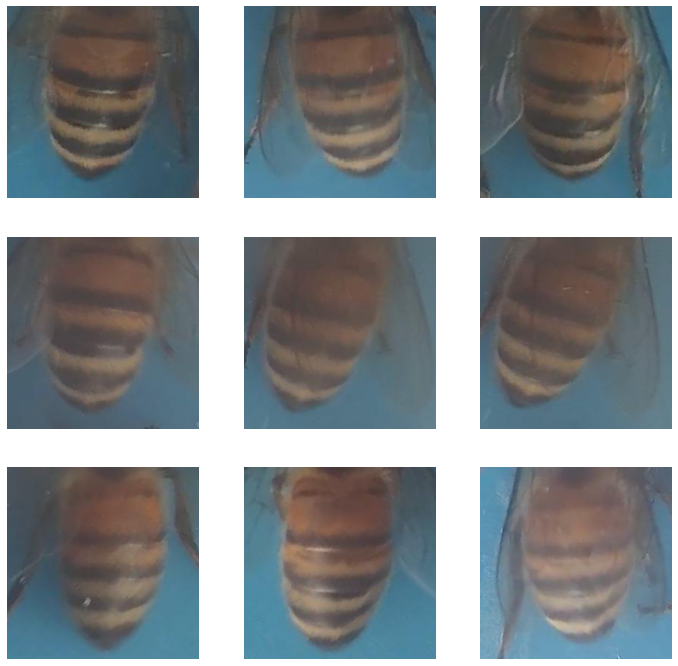

In [36]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
from random import shuffle
shuffle(short_images)
print(len(short_images))
for i, im in enumerate(short_images[:3]):
    ax[0, i].imshow(im[256:, 128:128*3])
    ax[0, i].axis('off')
    
for i, im in enumerate(long_images):
    ax[1, i].imshow(im[256:, 128:128*3])
    ax[1, i].axis('off')
    
for i, im in enumerate(neg_images):
    ax[2, i].imshow(im[256:, 128:128*3])
    ax[2, i].axis('off')
    
plt.savefig("dist.png")

In [37]:
benchmark = defaultdict(dict)

for ntrack, model_path in models.items():
    shortterm_mean_dist, short_distribution, longterm_mean_dist, long_distribution, notsame_mean_dist, notsame_distribution = eval_model_short_long_term(model_path)
    shortterm_diameter, short_diameter_distribution, longterm_diameter, long_diameter_distribution = eval_model_short_long_diameter(model_path)

    benchmark[ntrack]["shortterm_mean"] = shortterm_mean_dist
    benchmark[ntrack]["shortterm_hist"] = short_distribution
    benchmark[ntrack]["shortterm_diameter_mean"] = shortterm_diameter
    benchmark[ntrack]["shortterm_diameter_hist"] = short_diameter_distribution
    
    benchmark[ntrack]["longterm_mean"] = longterm_mean_dist
    benchmark[ntrack]["longterm_hist"] = long_distribution
    benchmark[ntrack]["longterm_diameter_mean"] = longterm_diameter
    benchmark[ntrack]["longterm_diameter_hist"] = long_diameter_distribution
    
    benchmark[ntrack]["notsame_mean"] = notsame_mean_dist
    benchmark[ntrack]["notsame_hist"] = notsame_distribution


/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 7s 69ms/step


  3%|▎         | 21/654 [00:00<00:03, 208.15it/s]

Evaluating 654 tracks.


  2%|▏         | 13/654 [00:00<00:05, 121.76it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:11<00:00, 54.56it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 13ms/step


  3%|▎         | 21/654 [00:00<00:03, 201.88it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:05<00:00, 122.60it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 13ms/step


  3%|▎         | 21/654 [00:00<00:03, 200.85it/s]

Evaluating 654 tracks.


  2%|▏         | 13/654 [00:00<00:05, 122.10it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:11<00:00, 57.59it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 13ms/step


  3%|▎         | 21/654 [00:00<00:03, 206.67it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:05<00:00, 124.84it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 14ms/step


  3%|▎         | 21/654 [00:00<00:03, 204.39it/s]

Evaluating 654 tracks.


  2%|▏         | 12/654 [00:00<00:05, 117.64it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:11<00:00, 55.83it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 4s 36ms/step


  3%|▎         | 18/654 [00:00<00:03, 176.37it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:05<00:00, 116.66it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 4s 41ms/step


  3%|▎         | 21/654 [00:00<00:03, 207.12it/s]

Evaluating 654 tracks.


  2%|▏         | 12/654 [00:00<00:05, 110.58it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:11<00:00, 54.52it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 24s 234ms/step


  3%|▎         | 17/654 [00:00<00:03, 167.81it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:05<00:00, 127.91it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 14ms/step


  3%|▎         | 20/654 [00:00<00:03, 199.53it/s]

Evaluating 654 tracks.


  2%|▏         | 12/654 [00:00<00:05, 110.80it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:12<00:00, 52.83it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: code.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 14s 138ms/step


  2%|▏         | 15/654 [00:00<00:04, 143.62it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:04<00:00, 131.51it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 14ms/step


  3%|▎         | 21/654 [00:00<00:03, 200.25it/s]

Evaluating 654 tracks.


  2%|▏         | 13/654 [00:00<00:05, 128.09it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:11<00:00, 58.47it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 14ms/step


  3%|▎         | 20/654 [00:00<00:03, 198.06it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:05<00:00, 129.07it/s]


In [38]:
for ntrack in ntracks:
    print(ntrack, benchmark[ntrack]['shortterm_mean'], benchmark[ntrack]['longterm_mean'])

181 0.21730149 0.4980843684251885
362 0.36172116 0.7119656560149054
724 0.38222286 0.7442238385975367
1448 0.27568176 0.6020077908895555
2896 0.24691716 0.5661057748808626


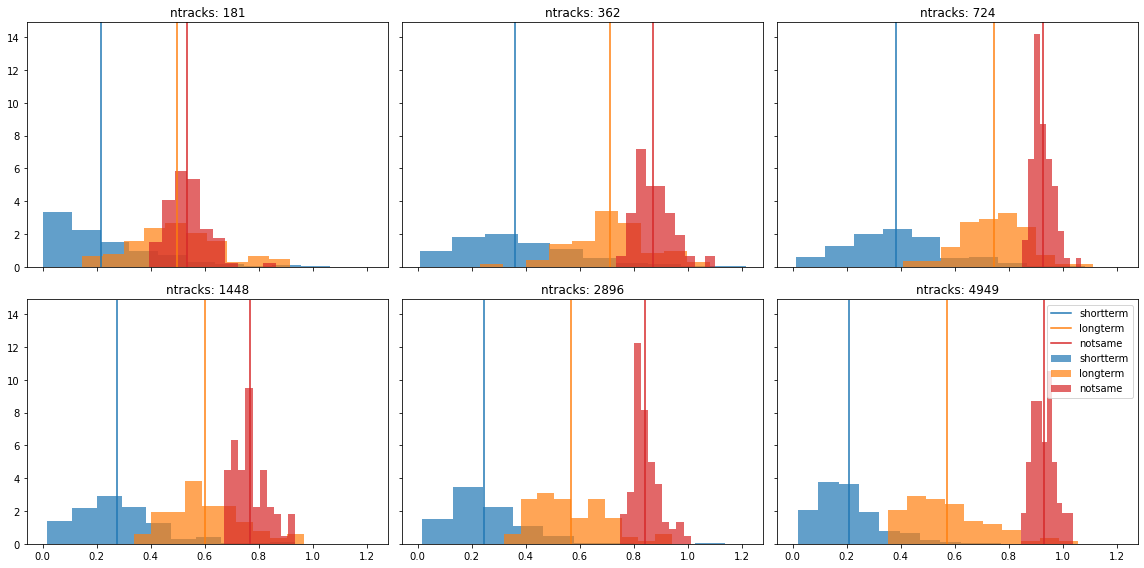

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(16, 8))
axes = ax.ravel()
for i, ntrack in enumerate(benchmark.keys()):
    axes[i].set_title("ntracks: {}".format(ntrack))
    axes[i].hist(benchmark[ntrack]["shortterm_hist"], label="shortterm", color="tab:blue", density=True, alpha=0.7)
    axes[i].axvline(benchmark[ntrack]["shortterm_mean"], color="tab:blue", label="shortterm")
    
    axes[i].hist(benchmark[ntrack]["longterm_hist"], label="longterm", color="tab:orange", density=True, alpha=0.7)
    axes[i].axvline(benchmark[ntrack]["longterm_mean"], color="tab:orange", label="longterm")
    
    axes[i].hist(benchmark[ntrack]["notsame_hist"], label="notsame", color="tab:red", density=True, alpha=0.7)
    axes[i].axvline(benchmark[ntrack]["notsame_mean"], color="tab:red", label="notsame")
plt.tight_layout()
plt.legend();
plt.savefig("distancedistribution_ntracks.png")

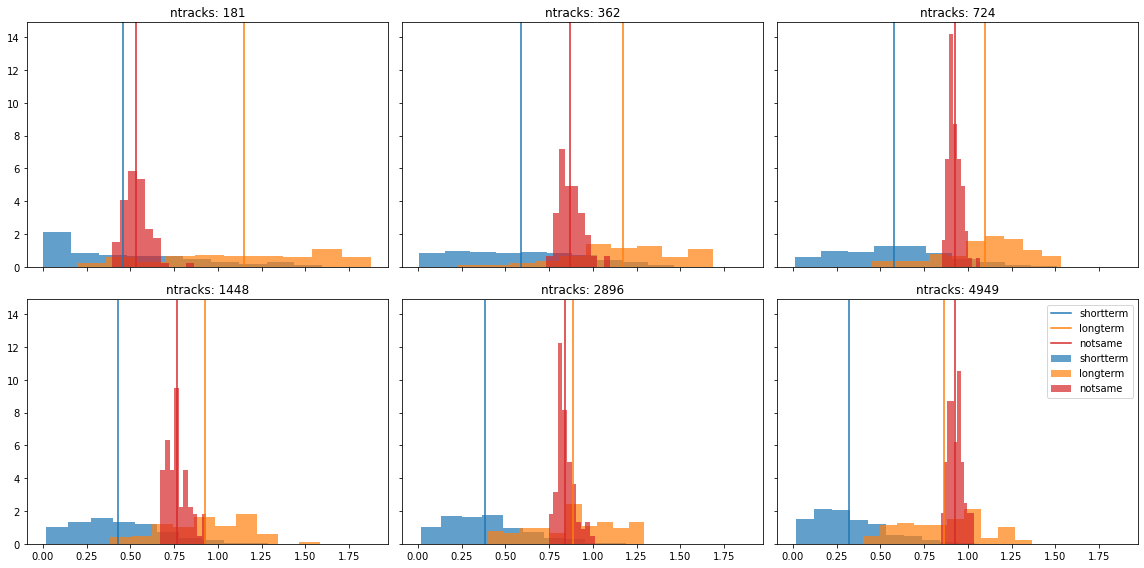

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(16, 8))
axes = ax.ravel()
for i, ntrack in enumerate(benchmark.keys()):
    axes[i].set_title("ntracks: {}".format(ntrack))
    axes[i].hist(benchmark[ntrack]["shortterm_diameter_hist"], label="shortterm", color="tab:blue", density=True, alpha=0.7)
    axes[i].axvline(benchmark[ntrack]["shortterm_diameter_mean"], color="tab:blue", label="shortterm")
    
    axes[i].hist(benchmark[ntrack]["longterm_diameter_hist"], label="longterm", color="tab:orange", density=True, alpha=0.7)
    axes[i].axvline(benchmark[ntrack]["longterm_diameter_mean"], color="tab:orange", label="longterm")
    
    axes[i].hist(benchmark[ntrack]["notsame_hist"], label="notsame", color="tab:red", density=True, alpha=0.7)
    axes[i].axvline(benchmark[ntrack]["notsame_mean"], color="tab:red", label="notsame")
plt.tight_layout()
plt.legend();
plt.savefig("diameterdistribution_ntracks.png")


In [42]:
models = {
    "tagged": "/home/jchan/beeid/notebooks/cmc_experiments/models2/2111240358_tagged_simplecnnv2_convb3_dim_128/model.tf",
    "untagged": "/home/jchan/beeid/notebooks/cmc_experiments/models2/2111232311_untagged_simplecnnv2_convb3_dim_128/model.tf",
    "tagged_untagged": "/home/jchan/beeid/notebooks/cmc_experiments/models2/2111241016_tagged_untagged_simplecnnv2_convb3_dim_128/model.tf",
    "tagged_augmentataion": "/home/jchan/beeid/notebooks/cmc_experiments/models2/2111232233_tagged_augmentataion_simplecnnv2_convb3_dim_128/model.tf",
    "untagged_augmentation": "/home/jchan/beeid/notebooks/cmc_experiments/models2/2111231639_untagged_augmentataion_simplecnnv2_convb3_dim_128/model.tf",
    "tagged_augmentataion_untagged_augmentataion":"/home/jchan/beeid/notebooks/cmc_experiments/models2/2111240952_tagged_augmentataion_untagged_augmentataion_simplecnnv2_convb3_dim_128/model.tf",
}

benchmark2 = defaultdict(dict)

for model_name, model_path in models.items():
    shortterm_mean_dist, short_distribution, longterm_mean_dist, long_distribution, notsame_mean_dist, notsame_distribution = eval_model_short_long_term(model_path)
    shortterm_diameter, short_diameter_distribution, longterm_diameter, long_diameter_distribution = eval_model_short_long_diameter(model_path)

    benchmark2[model_name]["shortterm_mean"] = shortterm_mean_dist
    benchmark2[model_name]["shortterm_hist"] = short_distribution
    benchmark2[model_name]["shortterm_diameter_mean"] = shortterm_diameter
    benchmark2[model_name]["shortterm_diameter_hist"] = short_diameter_distribution
    
    benchmark2[model_name]["longterm_mean"] = longterm_mean_dist
    benchmark2[model_name]["longterm_hist"] = long_distribution
    benchmark2[model_name]["longterm_diameter_mean"] = longterm_diameter
    benchmark2[model_name]["longterm_diameter_hist"] = long_diameter_distribution
    
    benchmark2[model_name]["notsame_mean"] = notsame_mean_dist
    benchmark2[model_name]["notsame_hist"] = notsame_distribution
    

/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 9s 88ms/step


  3%|▎         | 20/654 [00:00<00:03, 198.84it/s]

Evaluating 654 tracks.


  2%|▏         | 12/654 [00:00<00:05, 111.67it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:12<00:00, 54.41it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 2s 15ms/step


  3%|▎         | 21/654 [00:00<00:03, 200.56it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:05<00:00, 117.41it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 14ms/step


  3%|▎         | 21/654 [00:00<00:03, 201.23it/s]

Evaluating 654 tracks.


  1%|▏         | 9/654 [00:00<00:07, 84.35it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:12<00:00, 52.01it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 14ms/step


  3%|▎         | 20/654 [00:00<00:03, 199.03it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:05<00:00, 118.85it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 14ms/step


  3%|▎         | 20/654 [00:00<00:03, 196.94it/s]

Evaluating 654 tracks.


  2%|▏         | 12/654 [00:00<00:05, 108.70it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:12<00:00, 50.56it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 18s 172ms/step


  3%|▎         | 20/654 [00:00<00:03, 199.52it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:05<00:00, 123.31it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 14ms/step


  3%|▎         | 21/654 [00:00<00:03, 199.27it/s]

Evaluating 654 tracks.


  2%|▏         | 11/654 [00:00<00:05, 108.51it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:12<00:00, 52.82it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 14ms/step


  3%|▎         | 20/654 [00:00<00:03, 192.96it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:05<00:00, 121.52it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 14ms/step


  3%|▎         | 20/654 [00:00<00:03, 194.62it/s]

Evaluating 654 tracks.


  2%|▏         | 12/654 [00:00<00:06, 106.90it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:11<00:00, 56.93it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 10s 101ms/step


  3%|▎         | 20/654 [00:00<00:03, 193.89it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:05<00:00, 121.02it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 2s 15ms/step


  3%|▎         | 20/654 [00:00<00:03, 196.69it/s]

Evaluating 654 tracks.


  2%|▏         | 12/654 [00:00<00:05, 111.10it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:12<00:00, 52.95it/s]
/home/jchan/anaconda3/envs/bees/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: beeid2.models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


103/103 [==============================] - 1s 14ms/step


  3%|▎         | 20/654 [00:00<00:03, 198.87it/s]

Evaluating 654 tracks.


100%|██████████| 654/654 [00:05<00:00, 121.93it/s]


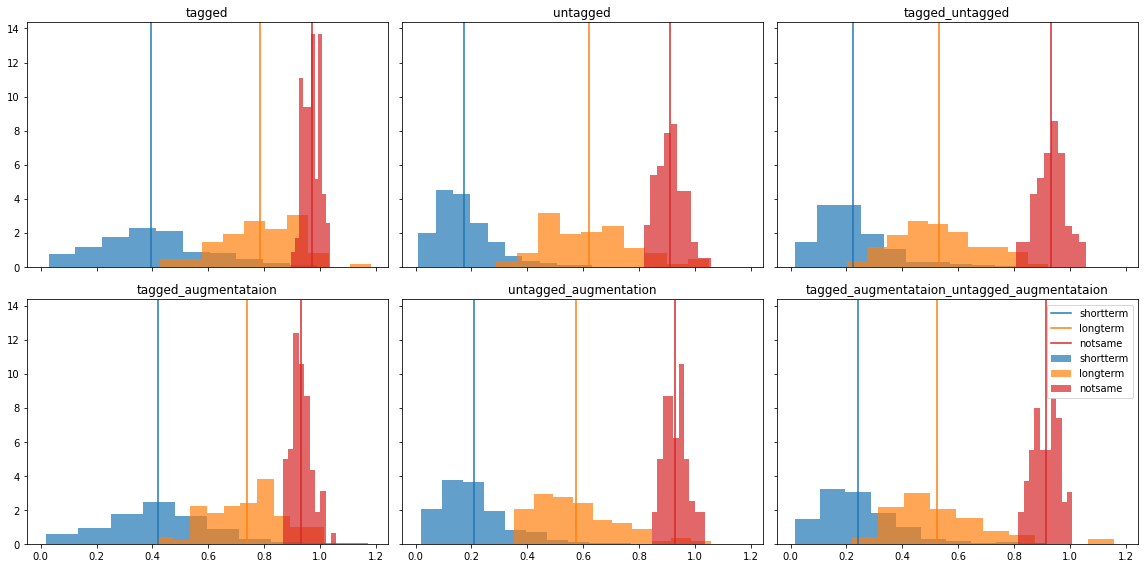

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(16, 8))
axes = ax.ravel()
for i, model_name in enumerate(models.keys()):
    axes[i].set_title("{}".format(model_name))
    axes[i].hist(benchmark2[model_name]["shortterm_hist"], label="shortterm", color="tab:blue", density=True, alpha=0.7)
    axes[i].axvline(benchmark2[model_name]["shortterm_mean"], color="tab:blue", label="shortterm")
    
    axes[i].hist(benchmark2[model_name]["longterm_hist"], label="longterm", color="tab:orange", density=True, alpha=0.7)
    axes[i].axvline(benchmark2[model_name]["longterm_mean"], color="tab:orange", label="longterm")
    
    axes[i].hist(benchmark2[model_name]["notsame_hist"], label="notsame", color="tab:red", density=True, alpha=0.7)
    axes[i].axvline(benchmark2[model_name]["notsame_mean"], color="tab:red", label="notsame")
plt.tight_layout()
plt.legend();
plt.savefig("distancedistribution.png")

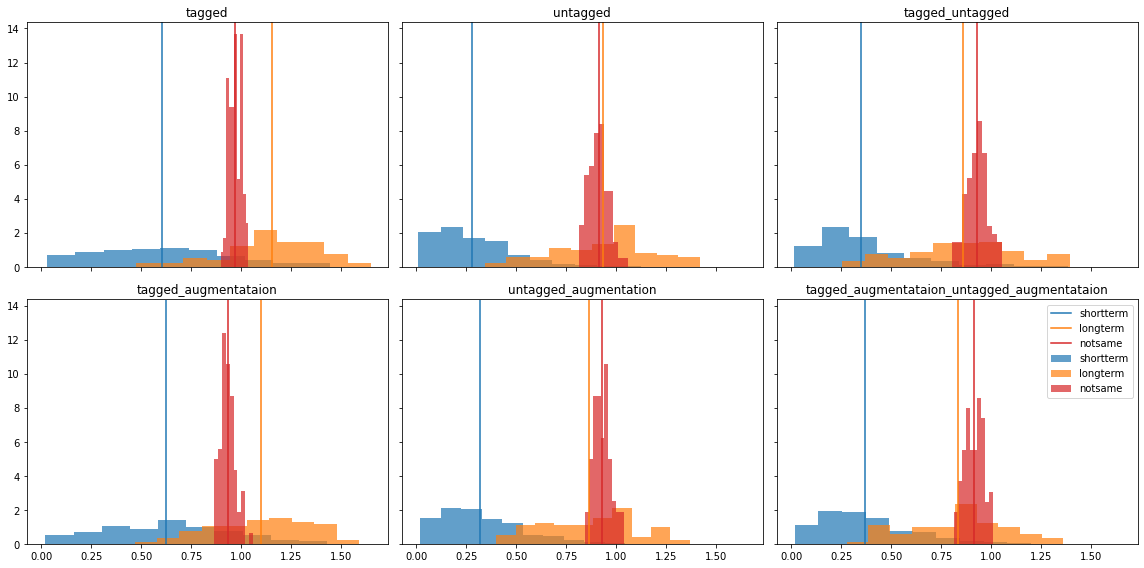

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(16, 8))
axes = ax.ravel()
for i, model_name in enumerate(models.keys()):
    axes[i].set_title("{}".format(model_name))
    axes[i].hist(benchmark2[model_name]["shortterm_diameter_hist"], label="shortterm", color="tab:blue", density=True, alpha=0.7)
    axes[i].axvline(benchmark2[model_name]["shortterm_diameter_mean"], color="tab:blue", label="shortterm")
    
    axes[i].hist(benchmark2[model_name]["longterm_diameter_hist"], label="longterm", color="tab:orange", density=True, alpha=0.7)
    axes[i].axvline(benchmark2[model_name]["longterm_diameter_mean"], color="tab:orange", label="longterm")
    
    axes[i].hist(benchmark2[model_name]["notsame_hist"], label="notsame", color="tab:red", density=True, alpha=0.7)
    axes[i].axvline(benchmark2[model_name]["notsame_mean"], color="tab:red", label="notsame")
plt.tight_layout()
plt.legend();
plt.savefig("diameterdistribution.png")